In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import model_selection, metrics, preprocessing
import torch
import torch.nn as nn
import matplotlib.pyplot as pl
from torch.utils.data import DataLoader, Dataset

In [20]:
# device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device =torch.device('cpu')
device

device(type='cpu')

In [21]:
df=pd.read_csv('ml-latest-small/ratings.csv')

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [23]:
df.userId.nunique()

610

In [24]:
df.movieId.nunique()

9724

In [25]:
df.rating.value_counts()

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64

In [26]:
df.shape

(100836, 4)

### Training Dataset CLass Wrapper

In [27]:
class MovieDataset:
    def __init__(self, users, movies,ratings):
        self.users= users
        self.movies = movies
        self.ratings = ratings
    def __len__(self):
        return len(self.users)
    def __getitem__(self, item):

        users = self.users[item]
        movies = self.users[item]
        ratings = self.ratings[item]

        return {
            "users": torch.tensor(users, dtype=torch.long),
            "movies": torch.tensor(movies,dtype=torch.long),
            "ratings": torch.tensor(ratings, dtype=torch.long)
        }


##### Create model

In [28]:
class RecSysModel(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()


        self.user_embed = nn.Embedding(n_users, 32)
        self.movie_embed = nn.Embedding(n_movies, 32)

        self.out = nn.Linear(64, 1)

    def forward(self, users, movies, ratings=None):
        user_embeds =self.user_embed(users)
        movie_embeds =self.movie_embed(movies)

        output = torch.cat([user_embeds, movie_embeds], dim=1)

        output = self.out(output)

        return  output


In [29]:
# encode ids start from 0 because of index out of bound error

lbl_user = preprocessing.LabelEncoder()
lbl_movie = preprocessing.LabelEncoder()

df.userId = lbl_user.fit_transform(df.userId)
df.movieId = lbl_movie.fit_transform(df.movieId)

df_train , df_valid = model_selection.train_test_split(df, test_size=0.1, random_state=42, stratify=df.rating.values)

train_dataset = MovieDataset(
    users= df_train.userId.values,
    movies=df_train.movieId.values,
    ratings=df_train.rating.values
)

valid_dataset = MovieDataset(
    users= df_valid.userId.values,
    movies=df_valid.movieId.values,
    ratings=df_train.rating.values
)

In [30]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=4,
                          shuffle=True)
validation_loader = DataLoader(dataset=valid_dataset,
                          batch_size=4,
                          shuffle=True)


In [31]:
dataiter = iter(train_loader)
dataloader_data = dataiter.next()
print(dataloader_data)

{'users': tensor([ 66, 516, 215, 561]), 'movies': tensor([ 66, 516, 215, 561]), 'ratings': tensor([2, 3, 4, 4])}


<ipython-input-27-a937652cf7ac>:17: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "ratings": torch.tensor(ratings, dtype=torch.long)


In [32]:
model = RecSysModel(
    n_users=len(lbl_user.classes_),
    n_movies=len(lbl_movie.classes_)
).to(device)

optimizer = torch.optim.Adam(model.parameters())
sch = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)

loss_func = nn.MSELoss()

In [33]:
print(len(lbl_user.classes_))
print(len(lbl_movie.classes_))
print(df.movieId.max())
print(len(train_dataset))

610
9724
9723
90752


### Manually Running

print(dataloader_data['users'])

print(dataloader_data['users'].size())
print(dataloader_data['movies'])

print(dataloader_data['movies'].size())

print(dataloader_data['ratings'].view(4,-1))

print(dataloader_data['ratings'].view(4,-1).size())

user_embed = nn.Embedding(len(lbl_user.classes_), 32)
movie_embed = nn.Embedding(len(lbl_movie.classes_), 32)

out = nn.Linear(64,1)


user_embeds = user_embed(dataloader_data['users'])
movie_embeds = user_embed(dataloader_data['movies'])

print(f'user_embeds size : {user_embeds.size()}')
print(f'user_embeds : {user_embeds}')

print(f'movie_embeds size: {movie_embeds.size()}')
print(f'movie_embeds : {movie_embeds}')




output = torch.cat([user_embeds,movie_embeds], dim=1)
output

output = out(output)
output

with torch.no_grad():
    model_output = model(dataloader_data['users'],
                         dataloader_data['movies'])

    print(f'model_output: {model_output}, size : {model_output.size()}')


In [37]:
epochs = 1
total_loss = 0
plot_steps, print_steps = 5000, 5000
step_cnt = 0
all_losses_list = []

model.train()

for epoch_i in range(epochs):
    for i, train_data in enumerate(train_loader):
        output = model(train_data['users'],
                       train_data['movies'])

        rating = train_data['ratings'].view(4,-1).to(torch.float32)

        loss = loss_func( output, rating)
        total_loss += loss.sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        step_cnt += len(train_data['users'])

        if step_cnt % plot_steps == 0:
            avg_loss = total_loss / (len(train_data['users']) * plot_steps)
            print(f'epoch {epoch_i} loss at step: {step_cnt} is {avg_loss}')
            all_losses_list.append(avg_loss)
            total_loss = 0 # reset



<ipython-input-27-a937652cf7ac>:17: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "ratings": torch.tensor(ratings, dtype=torch.long)


epoch 0 loss at step: 5000 is 0.441190301374346
epoch 0 loss at step: 10000 is 0.17277668764274567
epoch 0 loss at step: 15000 is 0.10397992557482794
epoch 0 loss at step: 20000 is 0.07901023177364841
epoch 0 loss at step: 25000 is 0.07187060420103371
epoch 0 loss at step: 30000 is 0.06970896215047687
epoch 0 loss at step: 35000 is 0.06572424275670201
epoch 0 loss at step: 40000 is 0.06299293044353835
epoch 0 loss at step: 45000 is 0.06439307833607309
epoch 0 loss at step: 50000 is 0.06414071545335465
epoch 0 loss at step: 55000 is 0.06324900864390656
epoch 0 loss at step: 60000 is 0.06013192932778038
epoch 0 loss at step: 65000 is 0.062355756334215404
epoch 0 loss at step: 70000 is 0.06428059345837682
epoch 0 loss at step: 75000 is 0.0613428107585758
epoch 0 loss at step: 80000 is 0.06342059358054539
epoch 0 loss at step: 85000 is 0.06494912145994604
epoch 0 loss at step: 90000 is 0.06102485067015514


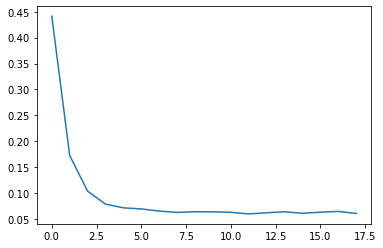

In [38]:
plt.figure()
plt.plot(all_losses_list)
plt.show()

#### Evaluation with RMSE

In [39]:
from sklearn.metrics import mean_squared_error

model_output_list = []
target_rating_list = []

model.eval()

with torch.no_grad():
    for i, batched_data in enumerate(validation_loader):
        model_output =model(batched_data['users'],
                            batched_data['movies']
                            )
        model_output_list.append(model_output.sum().item() / len(batched_data['users']))

        target_rating = batched_data['ratings']

        target_rating_list.append(target_rating.sum().item() / len(batched_data['users']))

        print(f' model output: {model_output}, target_ratings: {target_rating}')

rms = mean_squared_error(target_rating_list, model_output_list, squared=False)
print(f'rms: {rms}')


<ipython-input-27-a937652cf7ac>:17: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "ratings": torch.tensor(ratings, dtype=torch.long)


 model output: tensor([[3.8509],
        [2.7625],
        [3.1977],
        [3.6089]]), target_ratings: tensor([4, 2, 3, 4])
 model output: tensor([[3.2395],
        [3.3213],
        [3.3690],
        [3.0606]]), target_ratings: tensor([0, 3, 3, 2])
 model output: tensor([[3.4385],
        [3.1744],
        [3.6483],
        [3.0499]]), target_ratings: tensor([1, 4, 2, 1])
 model output: tensor([[3.4649],
        [3.3454],
        [2.8668],
        [2.8982]]), target_ratings: tensor([2, 4, 3, 0])
 model output: tensor([[3.3454],
        [3.5687],
        [3.5801],
        [2.8506]]), target_ratings: tensor([2, 4, 2, 4])
 model output: tensor([[3.3820],
        [4.0644],
        [3.3674],
        [3.5215]]), target_ratings: tensor([2, 4, 3, 4])
 model output: tensor([[3.6931],
        [3.4649],
        [3.0380],
        [3.3586]]), target_ratings: tensor([2, 2, 2, 3])
 model output: tensor([[3.3844],
        [3.6216],
        [2.7940],
        [2.8453]]), target_ratings: tensor([5, 5,

#### Evaluation with Recal@K

In [42]:
from collections import defaultdict

user_eat_true = defaultdict(list)

with torch.no_grad():
    for i, batched_data in enumerate(validation_loader):
        users = batched_data['users']
        movies = batched_data['movies']
        rating = batched_data['ratings']

        model_output = model(batched_data['users'], batched_data['movies'])

        for i in range(len(users)):
            user_id = users[i].item()
            movie_id = movies[i].item()
            pred_rating = model_output[i][0].item()
            true_rating = rating[i].item()

            print(f'{user_id}, {movie_id}, {pred_rating}, {true_rating}')

            user_eat_true[user_id].append((pred_rating, true_rating))



<ipython-input-27-a937652cf7ac>:17: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "ratings": torch.tensor(ratings, dtype=torch.long)


219, 219, 3.6866273880004883, 3
62, 62, 3.2206077575683594, 5
67, 67, 3.141122341156006, 5
18, 18, 2.739405393600464, 3
42, 42, 4.4284844398498535, 5
166, 166, 3.3625497817993164, 2
329, 329, 3.6575632095336914, 4
221, 221, 2.8678195476531982, 3
314, 314, 3.2134876251220703, 3
605, 605, 3.443037986755371, 3
490, 490, 4.15788459777832, 4
437, 437, 3.238757610321045, 1
20, 20, 3.304410934448242, 5
16, 16, 3.8589601516723633, 5
311, 311, 3.739605188369751, 4
569, 569, 3.1471028327941895, 2
139, 139, 3.38256573677063, 4
447, 447, 2.8982205390930176, 2
479, 479, 3.1275742053985596, 2
83, 83, 3.720707416534424, 4
413, 413, 3.4385061264038086, 4
216, 216, 2.749798536300659, 3
0, 0, 4.115608215332031, 3
106, 106, 3.6794705390930176, 5
445, 445, 3.230302333831787, 2
208, 208, 4.000124931335449, 3
297, 297, 2.363548994064331, 4
248, 248, 3.5095772743225098, 1
521, 521, 3.3586039543151855, 3
379, 379, 3.82840633392334, 3
413, 413, 3.4385061264038086, 5
176, 176, 2.9067821502685547, 3
308, 308, 3.

In [56]:
with torch.no_grad():
    precisions = dict()
    recalls =dict()

    k = 10

    threshold = 3.5

    for uid, user_ratings in user_eat_true.items():
        user_ratings.sort(key= lambda x : x[0], reverse=True)

        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        n_rec_k = sum((eat >= threshold) for (eat,_) in user_ratings[:k])

        n_rel_and_n_rec_k = sum((eat >= threshold) and (true_r >= threshold)  for (eat,true_r) in user_ratings[:k])

        print(f'uid {uid} , n_rel: {n_rel}, n_rec_k: {n_rec_k}, nrelANDnrecK: {n_rel_and_n_rec_k}')

        precisions[uid] = n_rel_and_n_rec_k / n_rec_k if n_rec_k != 0 else 0

        recalls[uid] = n_rel_and_n_rec_k / n_rel if n_rel != 0 else 0


uid 219 , n_rel: 15, n_rec_k: 10, nrelANDnrecK: 6
uid 62 , n_rel: 20, n_rec_k: 0, nrelANDnrecK: 0
uid 67 , n_rel: 69, n_rec_k: 0, nrelANDnrecK: 0
uid 18 , n_rel: 25, n_rec_k: 0, nrelANDnrecK: 0
uid 42 , n_rel: 5, n_rec_k: 9, nrelANDnrecK: 5
uid 166 , n_rel: 19, n_rec_k: 0, nrelANDnrecK: 0
uid 329 , n_rel: 11, n_rec_k: 10, nrelANDnrecK: 5
uid 221 , n_rel: 16, n_rec_k: 0, nrelANDnrecK: 0
uid 314 , n_rel: 0, n_rec_k: 0, nrelANDnrecK: 0
uid 605 , n_rel: 60, n_rec_k: 0, nrelANDnrecK: 0
uid 490 , n_rel: 6, n_rec_k: 7, nrelANDnrecK: 6
uid 437 , n_rel: 37, n_rec_k: 0, nrelANDnrecK: 0
uid 20 , n_rel: 17, n_rec_k: 0, nrelANDnrecK: 0
uid 16 , n_rel: 7, n_rec_k: 10, nrelANDnrecK: 6
uid 311 , n_rel: 11, n_rec_k: 10, nrelANDnrecK: 4
uid 569 , n_rel: 8, n_rec_k: 0, nrelANDnrecK: 0
uid 139 , n_rel: 25, n_rec_k: 0, nrelANDnrecK: 0
uid 447 , n_rel: 98, n_rec_k: 0, nrelANDnrecK: 0
uid 479 , n_rel: 43, n_rec_k: 0, nrelANDnrecK: 0
uid 83 , n_rel: 14, n_rec_k: 10, nrelANDnrecK: 3
uid 413 , n_rel: 117, n_rec

In [57]:
print(f'precision @{k}: {sum(prec for prec in precisions.values()) / len(precisions)}')
print(f'recall  @{k}: {sum(rec for rec in recalls.values()) / len(recalls)}')

precision @10: 0.26056944444444446
recall  @10: 0.4045052391177354
